In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
import joblib
from matplotlib import pyplot as plot
import os
import gc
from load_dataset import get_dataloader
import utils
import torch.multiprocessing as mp
import lightning.pytorch as pl
from lightning.pytorch.strategies import DDPStrategy
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint


c:\Users\Jean-Luc\.conda\envs\protein-protein\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
random_matrices = joblib.load('data/AA_random_matrices.joblib')

In [57]:
train, test = get_dataloader('data/Prots_embeddings_1d.joblib', random_matrices, shuffle=False, train_size=0.8, batch_size=64)

 Loading embeddings
 Handling embeddings
 Sequences done
 Found longest sequence: 1965
 Created the label matrices
Epoch 0:   0%|          | 0/544 [30:16<?, ?it/s]
 Embeddings done                                                   


In [110]:
class ConvNet1D(pl.LightningModule):
    def __init__(self, input_size, output_size, in_channels,
                 conv_k = 3, conv_s=1, conv_p=1, pool_k=2, pool_s=2,
                 use_batch_norm=False, dropout_rate = 0,
                 activation_function = nn.ReLU(), optimizer = optim.Adagrad, loss_func = nn.MSELoss()):
        super(ConvNet1D, self).__init__()
        self.layers = nn.ModuleList()
        self.in_channels = in_channels
        self.final_output_dim = output_size
        self.conv_k = conv_k
        self.conv_s = conv_s
        self.conv_p = conv_p
        self.pool_k = pool_k
        self.pool_s = pool_s
        out_dim = input_size
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.training_epoch_mean = []
        self.current_training_epoch_loss = []
        self.training_step_loss = []
        self.validation_epoch_mean = []
        self.current_validation_epoch_loss = []
        self.validation_step_loss = []
        self.lr = 0.001

        for i in range(len(self.in_channels)-1):
            self.layers.append(nn.Conv1d(self.in_channels[i], self.in_channels[i+1],  kernel_size=self.conv_k, stride=self.conv_s, padding=self.conv_p))
            self.layers.append(activation_function)
            self.layers.append(nn.MaxPool1d(kernel_size=self.pool_k, stride=self.pool_s))
            if use_batch_norm:
                self.layers.append(nn.BatchNorm1d(self.in_channels[i+1]))
            self.layers.append(nn.Dropout(p=dropout_rate))
            out_dim = self.compute_dim(out_dim, self.conv_k, self.conv_s, self.conv_p, self.pool_k, self.pool_s)
            
        self.conv_net = nn.Sequential(*self.layers)
        self.fc = nn.Linear(int(out_dim* self.in_channels[-1]), self.final_output_dim[0]*self.final_output_dim[1])
        
    def forward(self, x):
        out = self.conv_net(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out= out.view(out.shape[0], *self.final_output_dim)
        return out
    
    def compute_dim(self, dim, conv_k, conv_s, conv_p, pool_k, pool_s):
        dim = np.floor(((dim - conv_k + 2 * conv_p)/conv_s)+1)
        return np.floor(((dim - pool_k)/pool_s)+1)
    
    def validation_step(self, batch, batch_idx):
        loss, _, _ = self._common_step(batch, batch_idx)
        self.current_validation_epoch_loss.append(loss.detach().cpu().numpy())
        # self.log("validation_epoch_loss", loss, prog_bar=True)

        return loss
    
    def training_step(self, batch, batch_idx):
        loss, _, _ = self._common_step(batch, batch_idx)
        self.current_training_epoch_loss.append(loss.detach().cpu().numpy())
        return loss
    
    def _common_step(self, batch, batch_idx):
        data, labels = batch
        outputs = self.forward(data)
        loss = self.loss_func(outputs, labels)
        return loss, outputs, labels
    
    def configure_optimizers(self):
        return self.optimizer(self.parameters(), lr=self.lr)
    
    def on_train_epoch_end(self):
        epoch_loss = np.mean(self.current_training_epoch_loss)
        self.training_step_loss += self.current_training_epoch_loss
        self.training_epoch_mean.append(epoch_loss)
        self.log("train_epoch_loss", epoch_loss, prog_bar=True)
        self.current_training_epoch_loss.clear()

    def on_validation_epoch_end(self):
        epoch_loss = np.mean(self.current_validation_epoch_loss)
        self.validation_step_loss += self.current_validation_epoch_loss
        self.validation_epoch_mean.append(epoch_loss)
        self.log("validation_epoch_loss", epoch_loss, prog_bar=True)
        self.current_validation_epoch_loss.clear()

In [66]:
# checkpoint = ModelCheckpoint(
#     dirpath="checkpoints",
#     filename="{epoch}-{validation_epoch_loss:.1f}",
#     every_n_epochs=2,
#     save_top_k=-1
# )

In [ ]:
torch.set_float32_matmul_precision('medium')
early_stopping = EarlyStopping(monitor="validation_epoch_loss", patience=3, min_delta=0.00001, verbose=True)
model = ConvNet1D(1024, (1965,22), [1,2],  conv_k=2, optimizer=optim.AdamW, dropout_rate=0.2, use_batch_norm=True)
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=5, callbacks=[early_stopping], num_sanity_val_steps=0)
trainer.fit(model, train_dataloaders=test, val_dataloaders=test)


In [24]:
config = {
    'embeddings_path': ['data/Prots_embeddings_1d.joblib'],
    'random_matrices' : ['data/AA_random_matricies.joblib'],
    'output_shape': [(1965,22)],
    'embeddings_length': [1024],
    'epochs': [50],
    'channels':[[1,32,64],[1,16,32],[1,4,8,16], [1,16,32,64]],
    'conv_k': range(2,5),
    'conv_s': range(0,2),
    'conv_p': range(0,2),
    'pool_k': range(2,4),
    'pool_s': range(0,2),
    'activation_func': [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.LeakyReLU()],
    'loss_func': [nn.MSELoss(), nn.CrossEntropyLoss(), nn.L1Loss()],
    'optimizer' : [optim.SGD, optim.Adagrad, optim.AdamW],
    'training_size': [0.8],
    'batch_size' : [256],
    'dropout_rate' : [0, 0.25],
    'batch_normalization' : [True, False]
}


27648


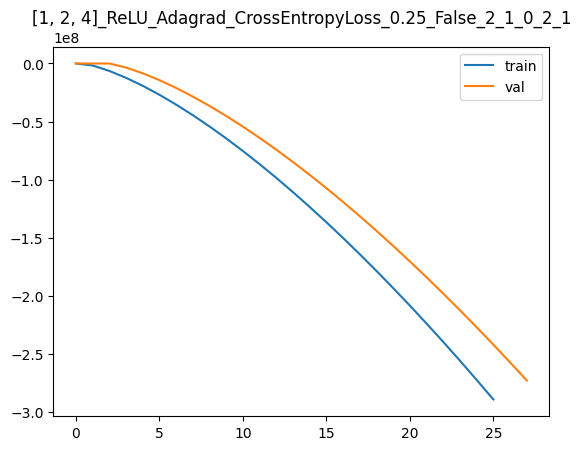

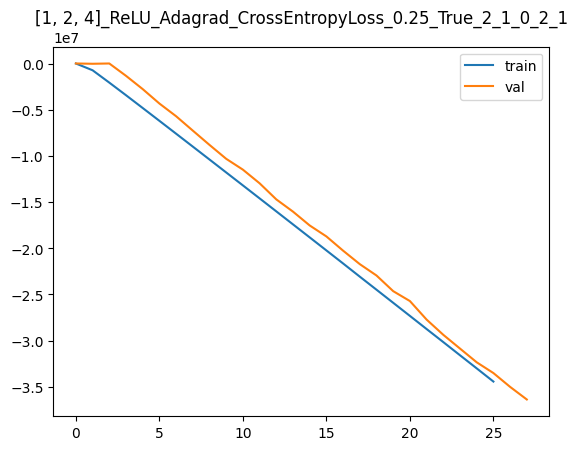

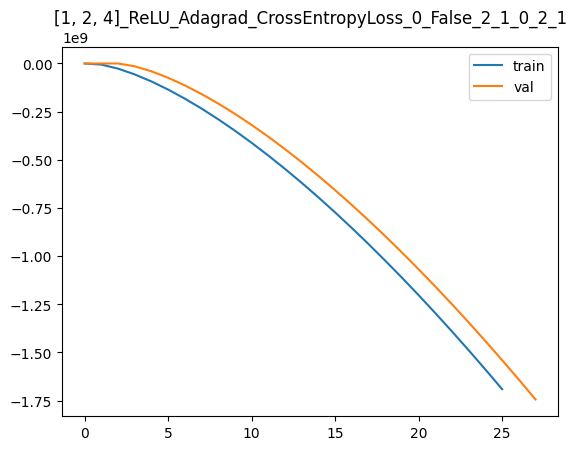

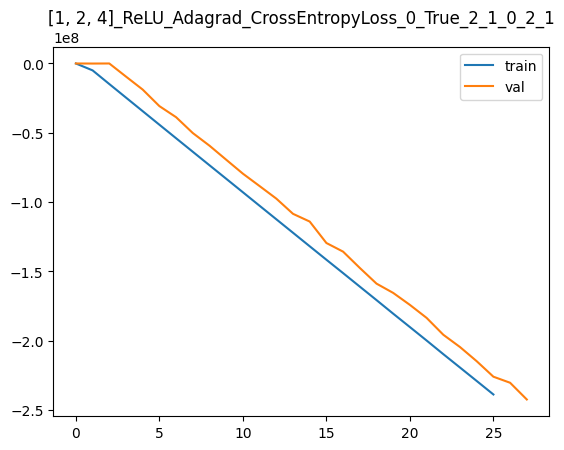

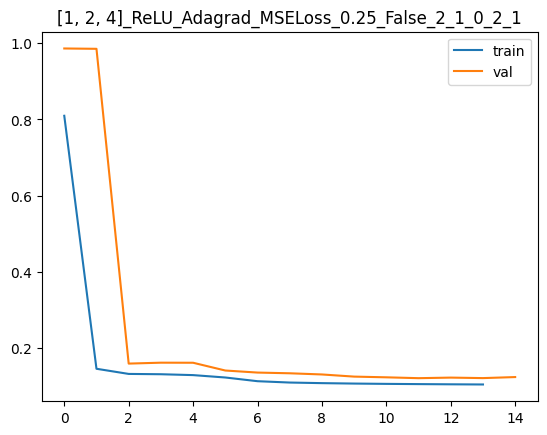

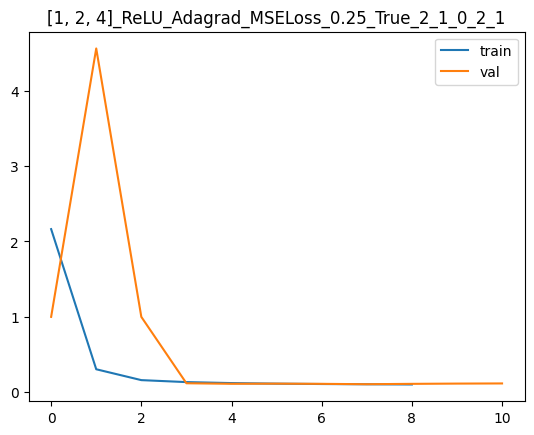

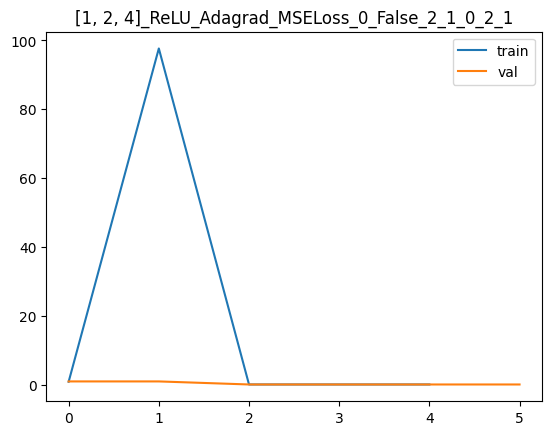

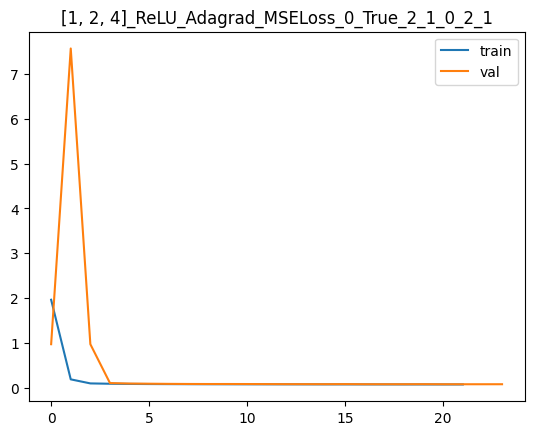

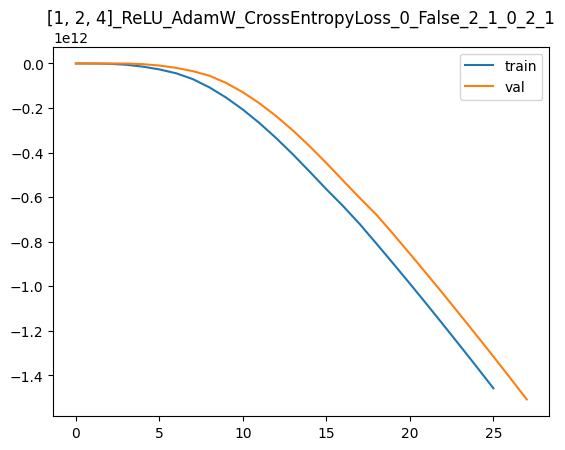

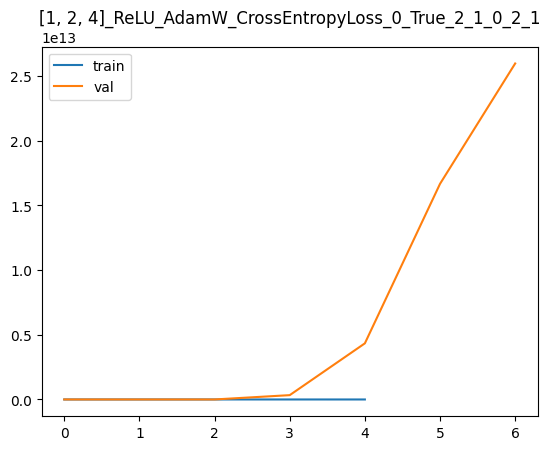

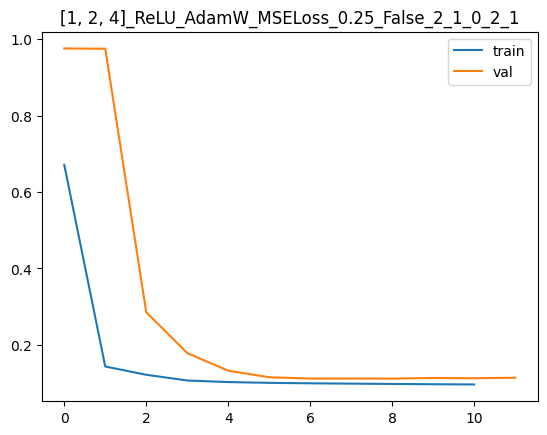

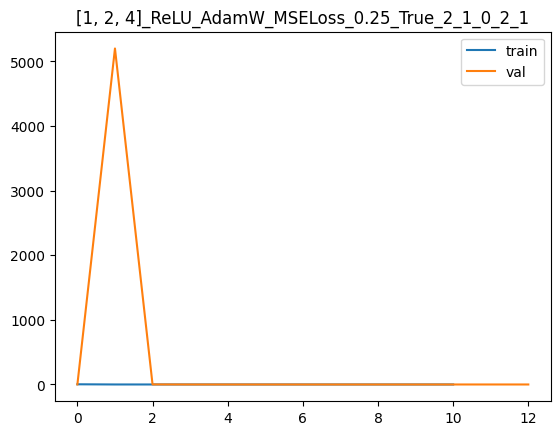

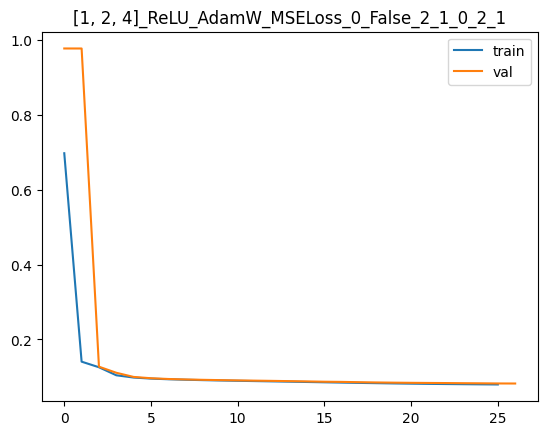

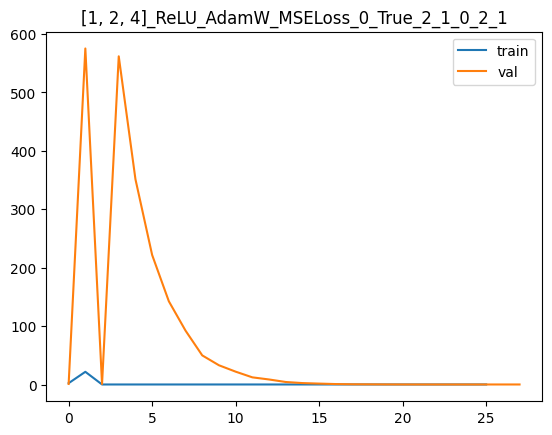

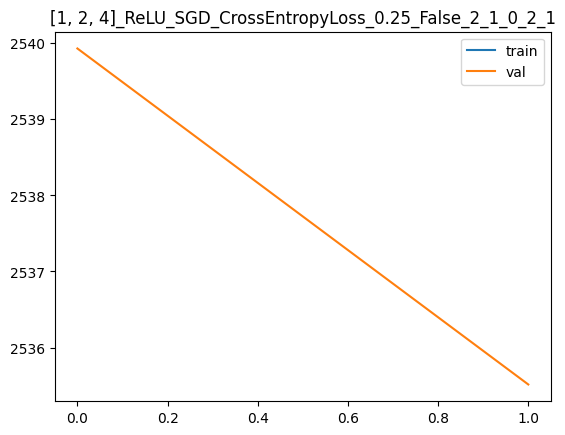

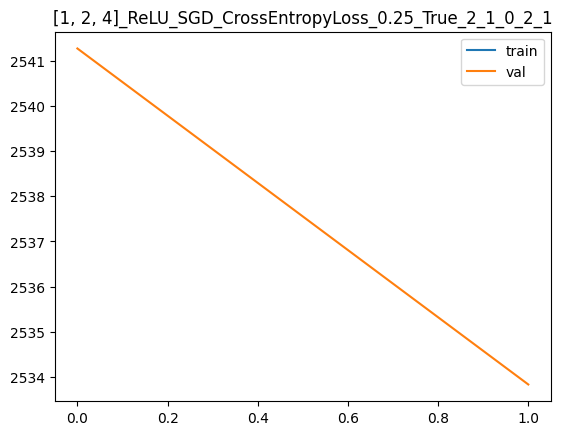

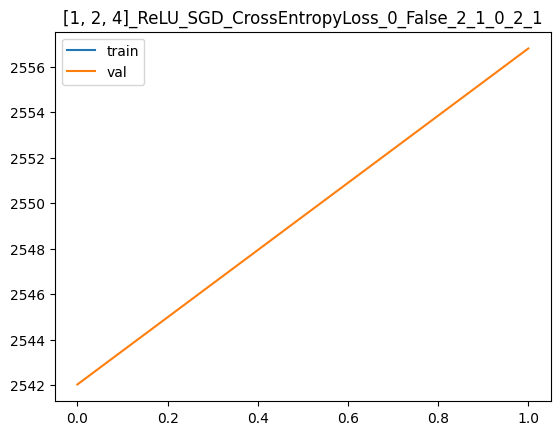

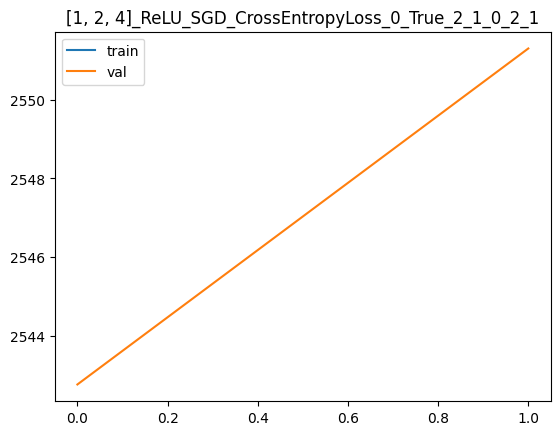

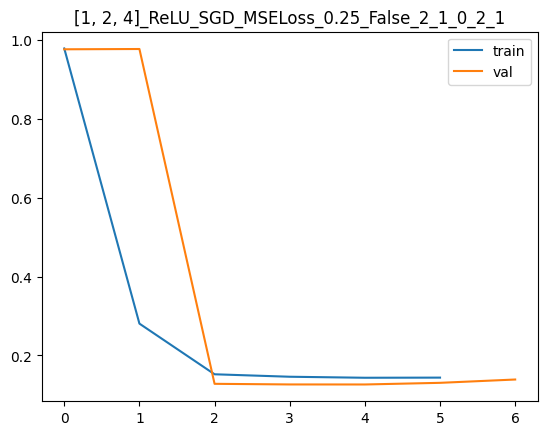

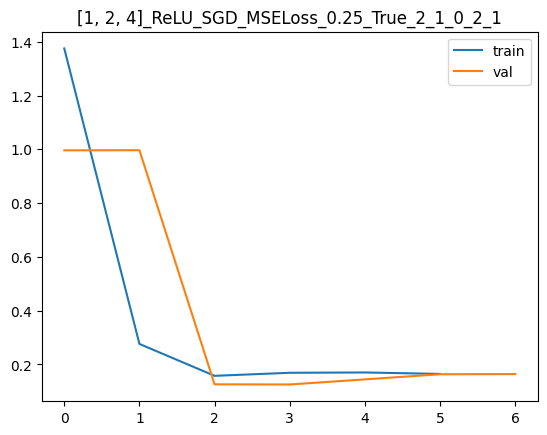

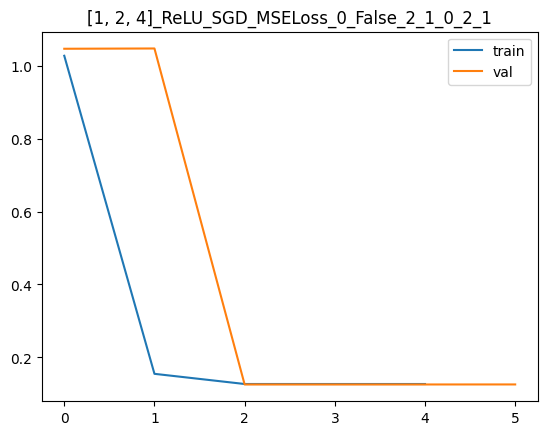

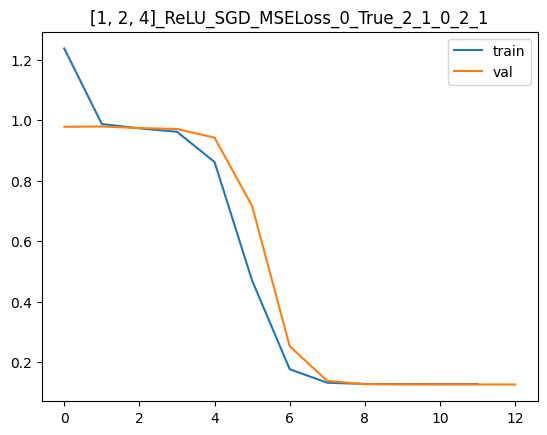

In [13]:
for name, model in models_4.items():
    plot.plot(range(len(model.training_epoch_mean)), model.training_epoch_mean, label='train')
    plot.plot(range(len(model.validation_epoch_mean)), model.validation_epoch_mean, label='val')
    plot.legend()
    plot.title(name)
    plot.show()

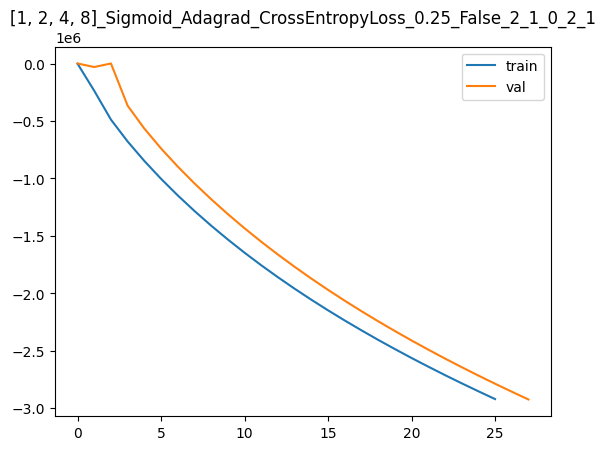

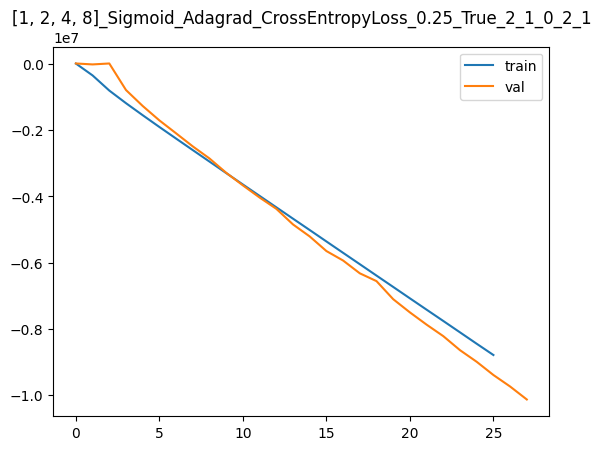

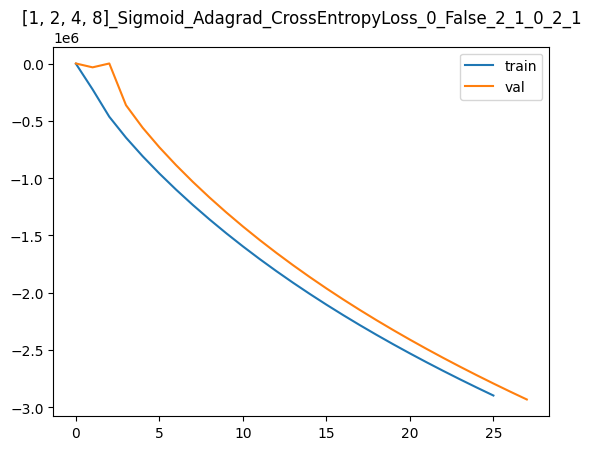

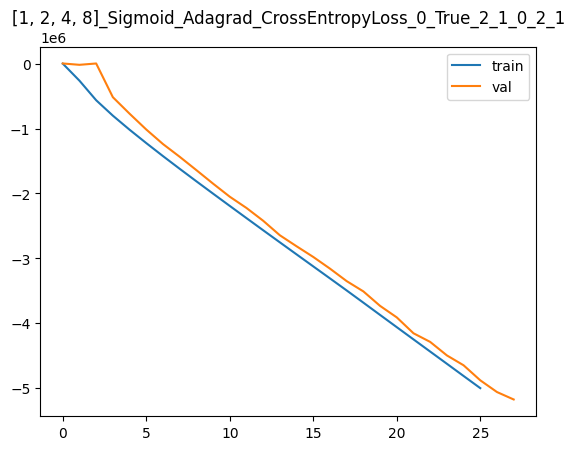

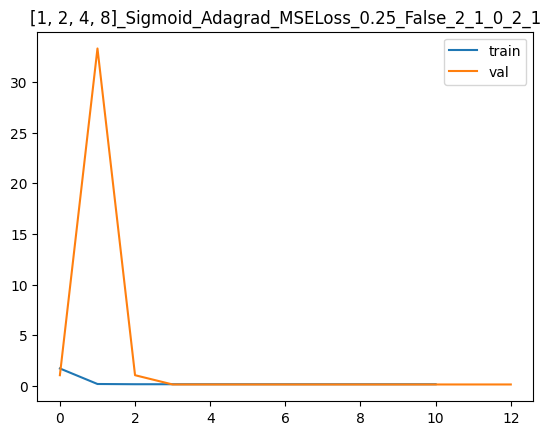

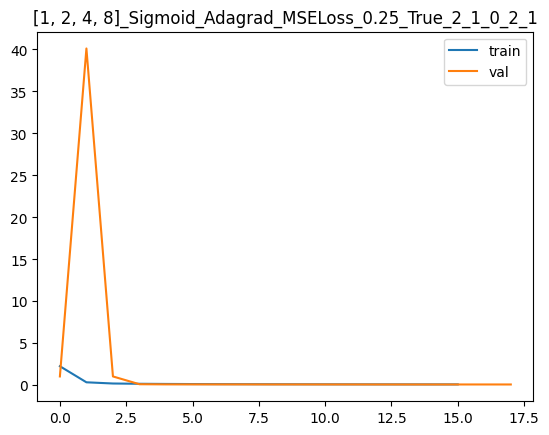

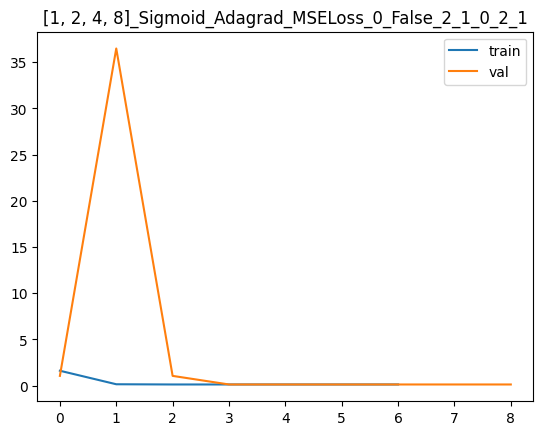

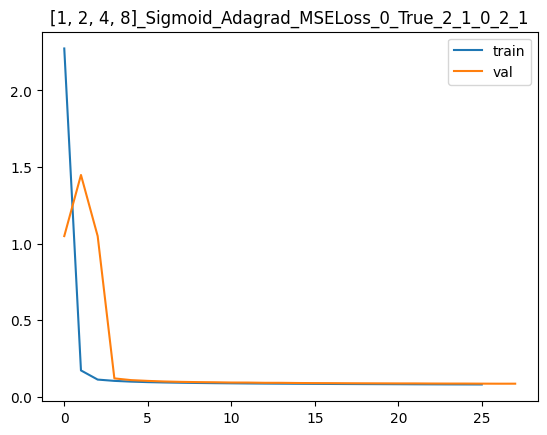

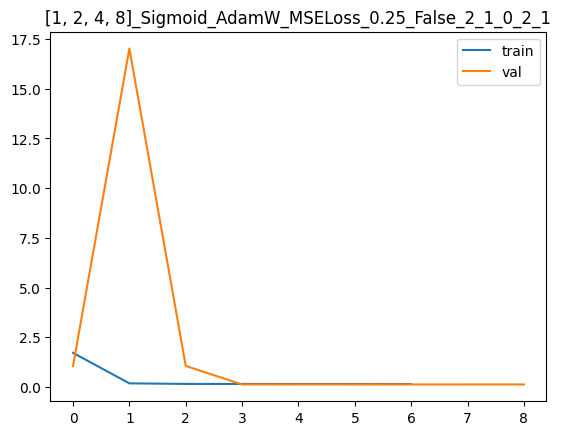

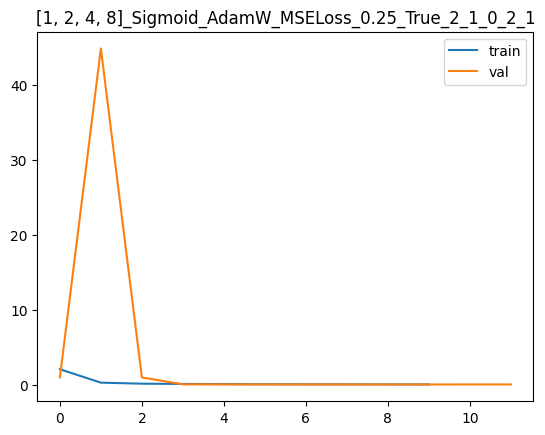

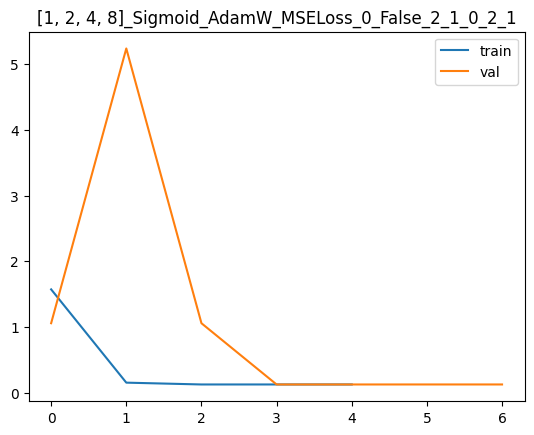

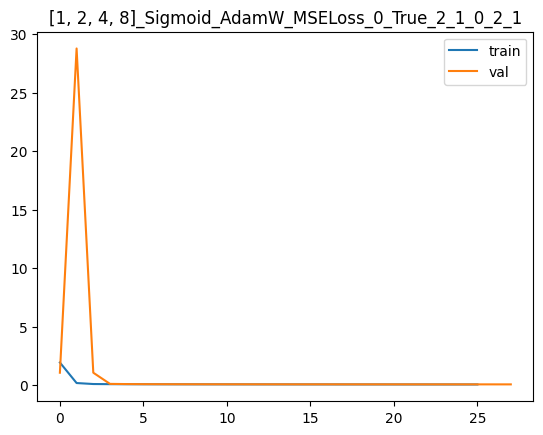

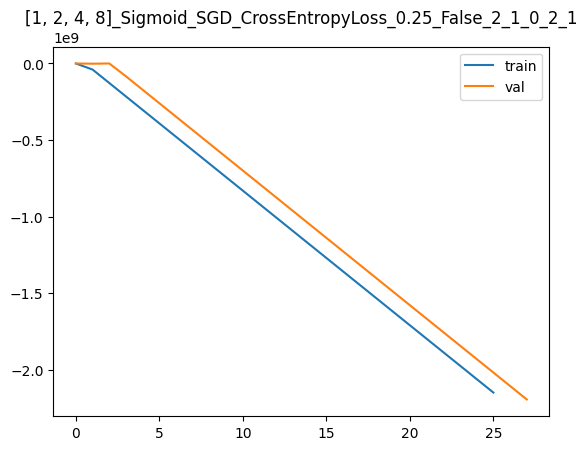

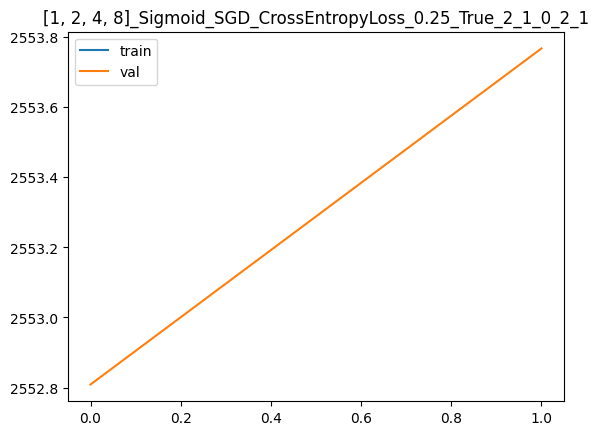

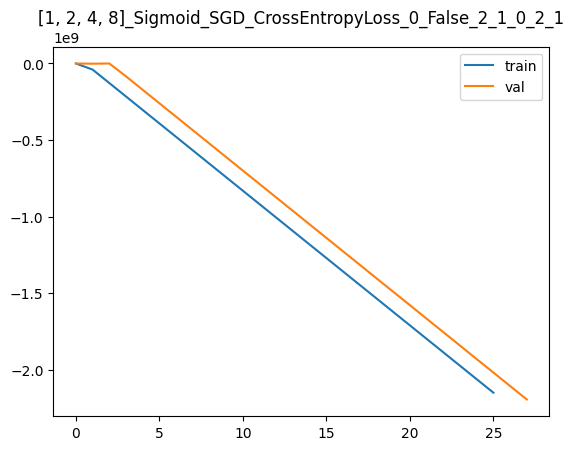

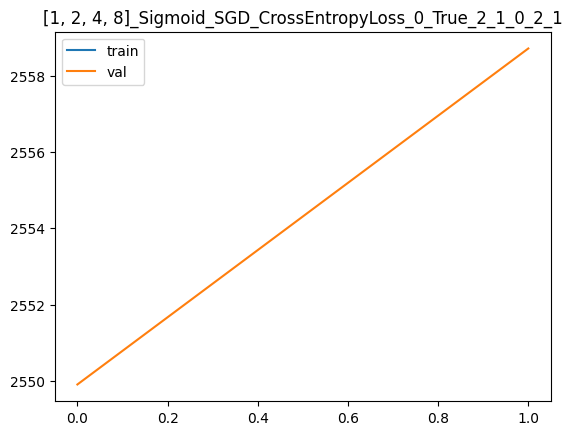

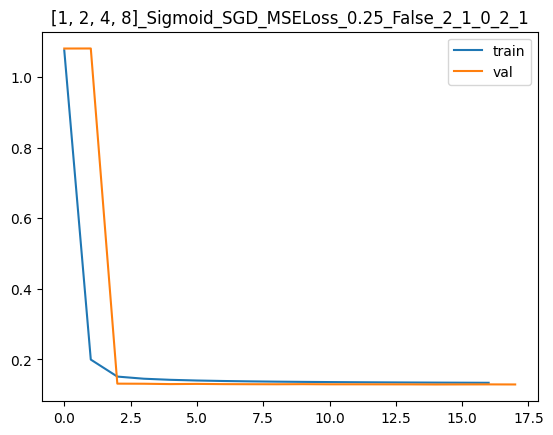

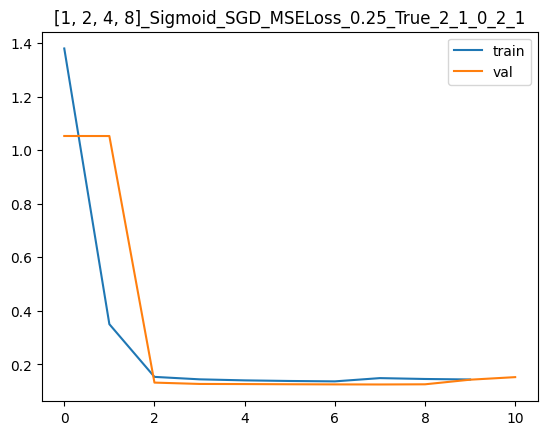

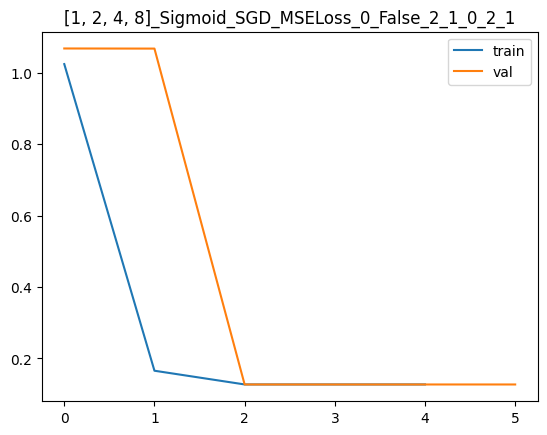

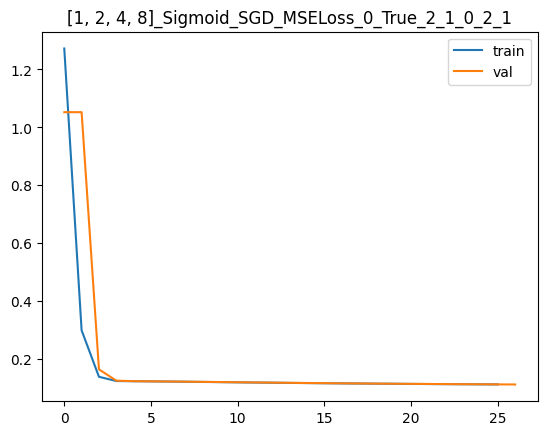

In [8]:
for name, model in models.items():
    plot.plot(range(len(model.training_epoch_mean)), model.training_epoch_mean, label='train')
    plot.plot(range(len(model.validation_epoch_mean)), model.validation_epoch_mean, label='val')
    plot.legend()
    plot.title(name)
    plot.show()